### TYK2 Replicate Subsampling

For a full-length TYK2 DMS dataset, re-sampling replicates is difficult due to the computational requirements of re-fitting the mixed model for each subsample in sufficient throughputt to enable inference. While we may do this regardless (or do so for an individual position or subset of positions), a much faster approach is to simply remove the last sample ("D") from each replicate group and regenerate the summary statistics as before. Having done so, we can directly compare the results for each variant:

In [44]:
library(magrittr)
library(ggpubr)
library(vroom)
library(scales)
library(scico)
library(knitr)
library(fs)
library(patchwork)
library(tidyverse)

In [3]:
sumstats_full <- read_tsv("../sumstats/TYK2/run3/tyk2_full_comparisons.tsv")

Rows: 236490 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): clone, chunk, aa, version, condition
dbl (7): pos, log2FoldChange, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
sumstats_sub <- dir_ls(path = "../sumstats/", regexp = "tyk2_.*combined.sumstats.tsv") %>%
    map_dfr(read_tsv, col_types = c("ncccnnnnnc")) %>%
    filter(grepl("aa",term), pos != 1188) %>%
    separate(term, c("condition", "aa"), ":") %>%
    mutate(condition = gsub("condition", "", condition),
           group = if_else(aa %in% c("mut_aa*", "mut_aaX"), chunk, "Non-Stop"),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa))

wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")

compute_difference <- function(test, control, sumstats) {
    
    df1 <- sumstats %>% filter(condition == test) %>% select(-condition)
    df2 <- sumstats %>% filter(condition == control) %>% select(-condition)
    
    df <- inner_join(df1, df2,
                     by = c("pos", "clone", "chunk", "aa", "version", "dispersion"))
    
    new_stats <- df %>%
        mutate(estimate = estimate.x - estimate.y,
               std.error = sqrt(std.error.x^2 + std.error.y^2)) %>%
        select(pos, clone, chunk, aa, estimate, std.error, dispersion, version) %>%
        ungroup()
    
    new_stats$condition = paste0(test, " - ", control)
    
    return(new_stats)
    
}

conditions <- unique(sumstats_sub$condition)
noneIdx <- which(conditions == "None0")
ifnbIdx <- which(conditions == "IFNbeta100")

sumstats_none_contr <- map_dfr(conditions[-noneIdx],
                         ~compute_difference(test = .,
                                            control = "None0",
                                            sumstats = sumstats_sub)) %>%
    mutate(condition = factor(condition,
                              levels = c("IFNbeta100 - None0",
                                         "IFNalpha1 - None0",
                                         "IFNalpha10 - None0",
                                         "IFNalpha100 - None0",
                                         "IFNalphaWithDrug100 - None0")))
sumstats_ifnb_contr <- map_dfr(conditions[-ifnbIdx],
                         ~compute_difference(test = .,
                                            control = "IFNbeta100",
                                            sumstats = sumstats_sub)) %>%
    mutate(condition = factor(condition,
                              levels = c("None0 - IFNbeta100",
                                         "IFNalpha1 - IFNbeta100",
                                         "IFNalpha10 - IFNbeta100",
                                         "IFNalpha100 - IFNbeta100",
                                         "IFNalphaWithDrug100 - IFNbeta100")))

sumstats_sub_all <- bind_rows(sumstats_none_contr, sumstats_ifnb_contr) %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
sumstats <- inner_join(sumstats_full, sumstats_sub_all, by = c("pos", "clone", "chunk", "condition", "version", "aa"))

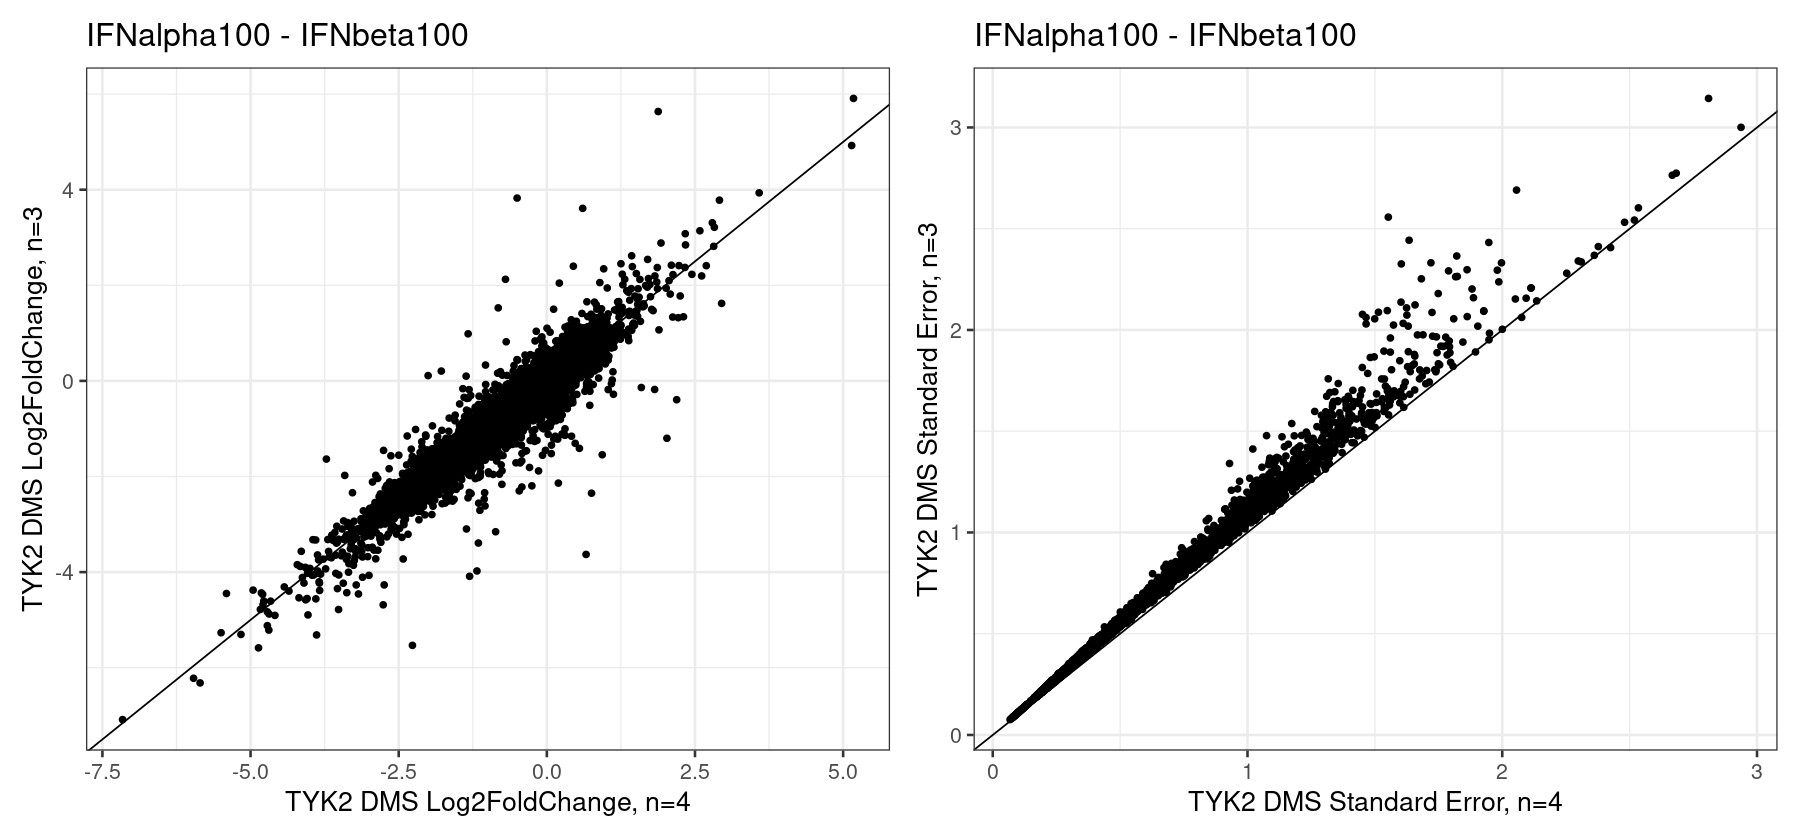

In [43]:
options(repr.plot.width = 15, repr.plot.height = 7)

p1 <- sumstats %>%
    filter(condition == "IFNalpha100 - IFNbeta100") %>%
    ggplot() +
        geom_point(aes(x = log2FoldChange, y = estimate/log(2))) +
        theme_bw(base_size = 16) +
        geom_abline(slope = 1, intercept = 0) +
        xlab("TYK2 DMS Log2FoldChange, n=4") + ylab("TYK2 DMS Log2FoldChange, n=3") +
        ggtitle("IFNalpha100 - IFNbeta100")

p2 <- sumstats %>%
    filter(condition == "IFNalpha100 - IFNbeta100") %>%
    ggplot() +
        geom_point(aes(x = std.error.x, y = std.error.y/log(2))) +
        theme_bw(base_size = 16) +
        geom_abline(slope = 1, intercept = 0) +
        xlab("TYK2 DMS Standard Error, n=4") + ylab("TYK2 DMS Standard Error, n=3") +
        ggtitle("IFNalpha100 - IFNbeta100")

p1 + p2

More interestingly, we can compare the Z-statistics to see what the differences in the final significant effect set look like:

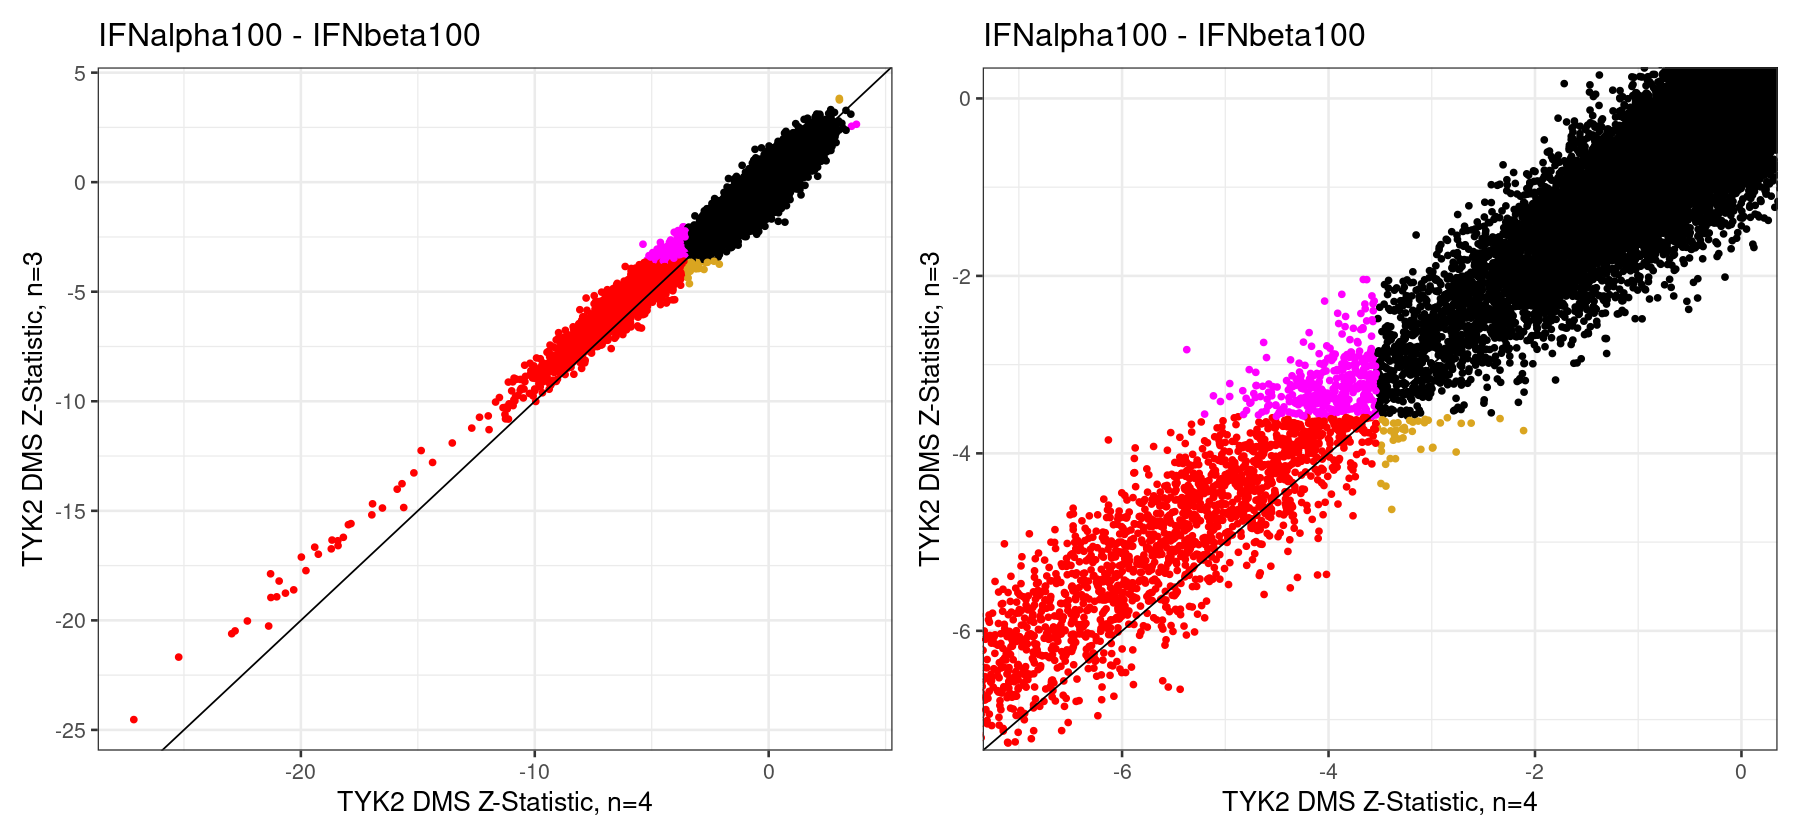

In [39]:
z_p1 <- sumstats %>%
    filter(condition == "IFNalpha100 - IFNbeta100") %>%
    ggplot() +
        geom_point(aes(x = statistic.x, y = statistic.y,
                       color = case_when(p.adj.x < 0.01 & p.adj.y < 0.01 ~ "red",
                                         p.adj.x < 0.01 & p.adj.y > 0.01 ~ "magenta",
                                         p.adj.x > 0.01 & p.adj.y < 0.01 ~ "goldenrod",
                                         TRUE ~ "black"))) +
        theme_bw(base_size = 16) +
        geom_abline(slope = 1, intercept = 0) +
        xlab("TYK2 DMS Z-Statistic, n=4") + ylab("TYK2 DMS Z-Statistic, n=3") +
        scale_color_identity()

z_p2 <- sumstats %>%
    filter(condition == "IFNalpha100 - IFNbeta100") %>%
    ggplot() +
        geom_point(aes(x = statistic.x, y = statistic.y,
                       color = case_when(p.adj.x < 0.01 & p.adj.y < 0.01 ~ "red",
                                         p.adj.x < 0.01 & p.adj.y > 0.01 ~ "magenta",
                                         p.adj.x > 0.01 & p.adj.y < 0.01 ~ "goldenrod",
                                         TRUE ~ "black"))) +
        theme_bw(base_size = 16) +
        geom_abline(slope = 1, intercept = 0) +
        xlab("TYK2 DMS Z-Statistic, n=4") + ylab("TYK2 DMS Z-Statistic, n=3") +
        coord_cartesian(xlim = c(-7,0), ylim = c(-7,0)) +
        scale_color_identity()

options(repr.plot.width = 15, repr.plot.height = 7)
z_p1 + z_p2 & ggtitle("IFNalpha100 - IFNbeta100")

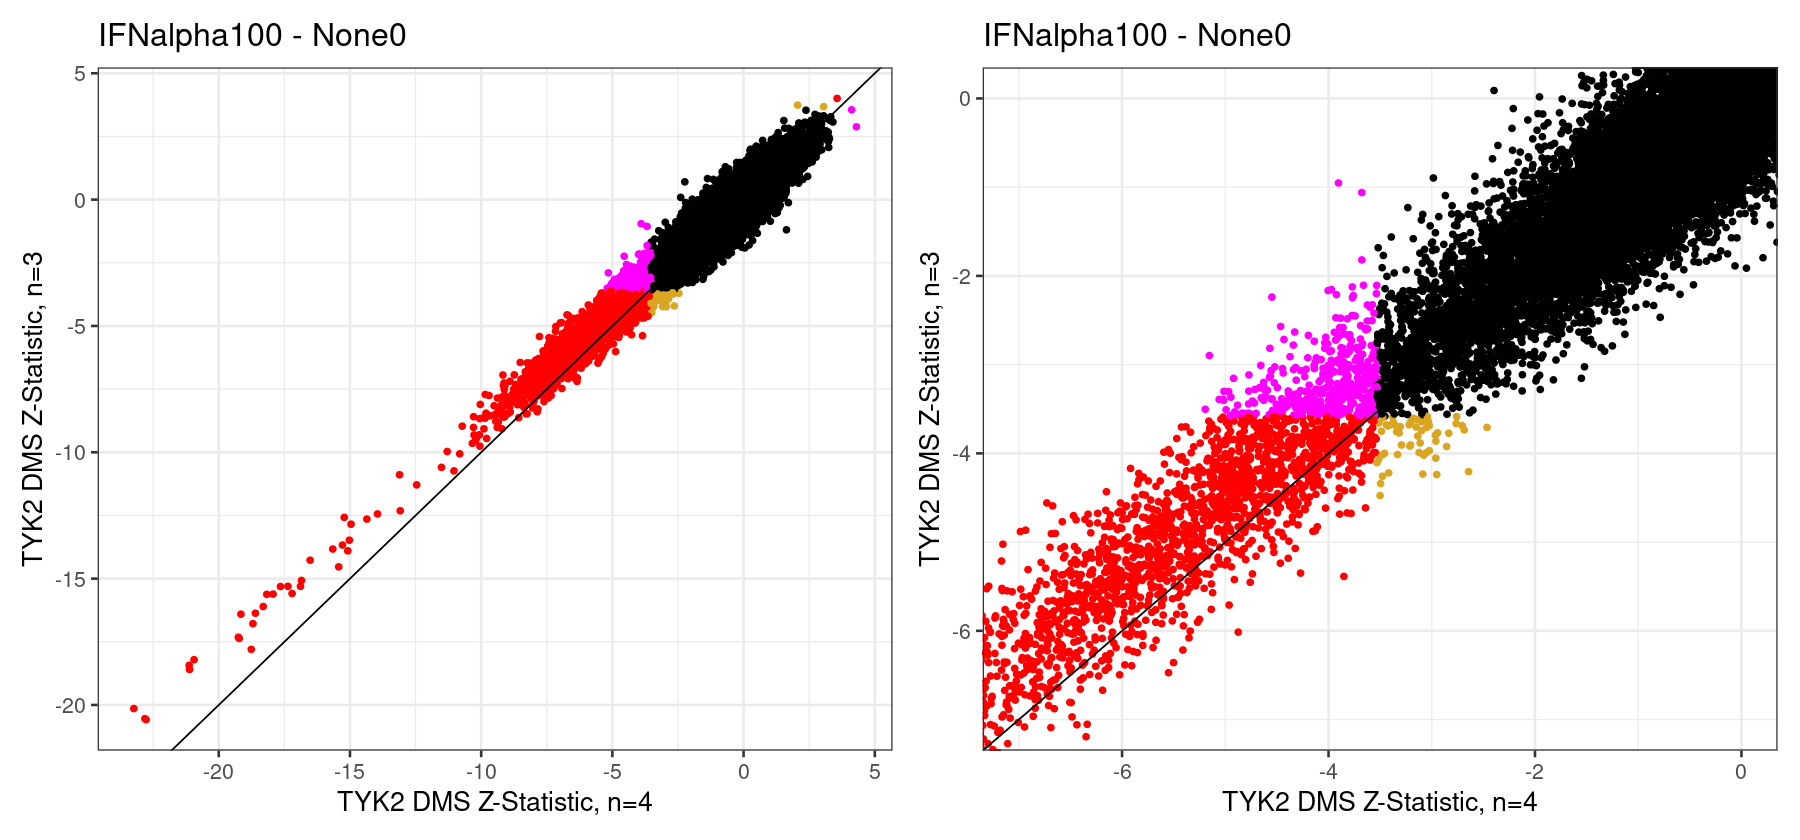

In [38]:
z_p1 <- sumstats %>%
    filter(condition == "IFNalpha100 - None0") %>%
    ggplot() +
        geom_point(aes(x = statistic.x, y = statistic.y,
                       color = case_when(p.adj.x < 0.01 & p.adj.y < 0.01 ~ "red",
                                         p.adj.x < 0.01 & p.adj.y > 0.01 ~ "magenta",
                                         p.adj.x > 0.01 & p.adj.y < 0.01 ~ "goldenrod",
                                         TRUE ~ "black"))) +
        theme_bw(base_size = 16) +
        geom_abline(slope = 1, intercept = 0) +
        xlab("TYK2 DMS Z-Statistic, n=4") + ylab("TYK2 DMS Z-Statistic, n=3") +
        scale_color_identity()

z_p2 <- sumstats %>%
    filter(condition == "IFNalpha100 - None0") %>%
    ggplot() +
        geom_point(aes(x = statistic.x, y = statistic.y,
                       color = case_when(p.adj.x < 0.01 & p.adj.y < 0.01 ~ "red",
                                         p.adj.x < 0.01 & p.adj.y > 0.01 ~ "magenta",
                                         p.adj.x > 0.01 & p.adj.y < 0.01 ~ "goldenrod",
                                         TRUE ~ "black"))) +
        theme_bw(base_size = 16) +
        geom_abline(slope = 1, intercept = 0) +
        xlab("TYK2 DMS Z-Statistic, n=4") + ylab("TYK2 DMS Z-Statistic, n=3") +
        coord_cartesian(xlim = c(-7,0), ylim = c(-7,0)) +
        scale_color_identity()

options(repr.plot.width = 15, repr.plot.height = 7)
z_p1 + z_p2 & ggtitle("IFNalpha100 - None0")

We can count up the number of variants that fall into each of these categories (significant in both, neither, or only one) in each of the comparisons. These values, shown as counts and percentages of total variants tested, are in the below tables:

In [52]:
sig_counts <- sumstats %>%
    mutate("signif" = case_when(p.adj.x < 0.01 & p.adj.y < 0.01 ~ "Both",
                                p.adj.x < 0.01 & p.adj.y > 0.01 ~ "N=4 Only",
                                p.adj.x > 0.01 & p.adj.y < 0.01 ~ "N=3 Only",
                                TRUE ~ "Neither")) %>%
    count(condition, signif) %>%
    group_by(condition) %>%
    mutate(prop = n*100/sum(n))

In [62]:
sig_counts %>%
    select(-prop) %>%
    mutate(normalization = if_else(grepl("- IFNbeta100", condition), "IFNbeta100", "None0"),
           condition = gsub(" .*", "", condition)) %>%
    filter(!condition %in% c("None0", "IFNbeta100")) %>%
    pivot_wider(names_from = signif, values_from = n) %>%
    arrange(normalization) %>%
    kable("markdown")



|condition           |normalization | Both| N=3 Only| N=4 Only| Neither|
|:-------------------|:-------------|----:|--------:|--------:|-------:|
|IFNalpha1           |IFNbeta100    |   43|       16|       57|   23498|
|IFNalpha10          |IFNbeta100    | 1882|       49|      573|   21110|
|IFNalpha100         |IFNbeta100    | 2257|       43|      345|   20969|
|IFNalphaWithDrug100 |IFNbeta100    |   25|       13|       18|   23558|
|IFNalpha1           |None0         |    5|        9|       10|   23590|
|IFNalpha10          |None0         | 1438|       71|      632|   21473|
|IFNalpha100         |None0         | 2030|       58|      391|   21135|
|IFNalphaWithDrug100 |None0         |    7|        4|        3|   23600|

In [64]:
sig_counts %>%
    select(-n) %>%
    mutate(normalization = if_else(grepl("- IFNbeta100", condition), "IFNbeta100", "None0"),
           condition = gsub(" .*", "", condition)) %>%
    filter(!condition %in% c("None0", "IFNbeta100")) %>%
    pivot_wider(names_from = signif, values_from = prop) %>%
    arrange(normalization) %>%
    kable("markdown")



|condition           |normalization |      Both|  N=3 Only|  N=4 Only|  Neither|
|:-------------------|:-------------|---------:|---------:|---------:|--------:|
|IFNalpha1           |IFNbeta100    | 0.1820954| 0.0677564| 0.2413822| 99.50877|
|IFNalpha10          |IFNbeta100    | 7.9698484| 0.2075040| 2.4265266| 89.39612|
|IFNalpha100         |IFNbeta100    | 9.5578894| 0.1820954| 1.4609977| 88.79902|
|IFNalphaWithDrug100 |IFNbeta100    | 0.1058694| 0.0550521| 0.0762260| 99.76285|
|IFNalpha1           |None0         | 0.0211739| 0.0381130| 0.0423478| 99.89837|
|IFNalpha10          |None0         | 6.0896079| 0.3006691| 2.6763784| 90.93334|
|IFNalpha100         |None0         | 8.5965952| 0.2456170| 1.6557974| 89.50199|
|IFNalphaWithDrug100 |None0         | 0.0296434| 0.0169391| 0.0127043| 99.94071|